In [16]:
import sys
sys.path.append('/Users/eran/Dropbox/ASU/SINE/python/')
from my_functions import db_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
eng = db_engine()

Inputs

In [17]:
criteria = 'rms'
candidates = 20 #filter to the best x candiadates

Get Data for voltage and angle evaluation at the specified criteria

In [18]:
sql = ("SELECT b.idint as id, a.caseid as case, a.value FROM linpf.vt a INNER JOIN linpf.idmap b ON a.id=b.id "
       "WHERE a.prop=%(prop)s and a.criteria=%(criteria)s "
       "ORDER BY b.id, a.caseid")
dfv = pd.read_sql_query(sql,eng,params={'prop': 'vol', 'criteria': criteria})
dfa = pd.read_sql_query(sql,eng,params={'prop': 'ang', 'criteria': criteria})

## Threshold to a few candidates
We align the data into a table with the id's as rows, the cases as columns and the value of the criteria as content.
The maximum value for each *id*, $d$, for each property, $x$, is calculated and these are sorted.
A threshold is decided by selecting the value of the $candidate$-th entry in the sorted list of maximum values.
This way when we filter, we'll have at least that many ids.
The data is now filtered using the threshold.

In [19]:
dfv2  = dfv.pivot(index='id', columns='case', values='value')
dfa2  = dfa.pivot(index='id', columns='case', values='value')
# sns.set(style="white")
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.heatmap(df2,cmap=cmap,vmax=1,yticklabels=100)
# plt.show()
threshold = {}
threshold['v'] = np.sort( dfv2.max(axis=1))[candidates-1]
threshold['a'] = np.sort( dfa2.max(axis=1))[candidates-1]
dfv3 = dfv.loc[dfv['value'] <= threshold['v'], :].pivot(index='id', columns='case', values='value')
dfv3 = dfv3.loc[dfv3.notnull().all(axis=1),:]
dfa3 = dfa.loc[dfa['value'] <= threshold['a'], :].pivot(index='id', columns='case', values='value')
dfa3 = dfa3.loc[dfa3.notnull().all(axis=1),:]

## Heat maps
The hit maps give a feel for how the given critera fairs both with respect to the ids, as well as the different cases.
Fairly solid looking vertical bars suggests that the ids perform similarly for a given case.

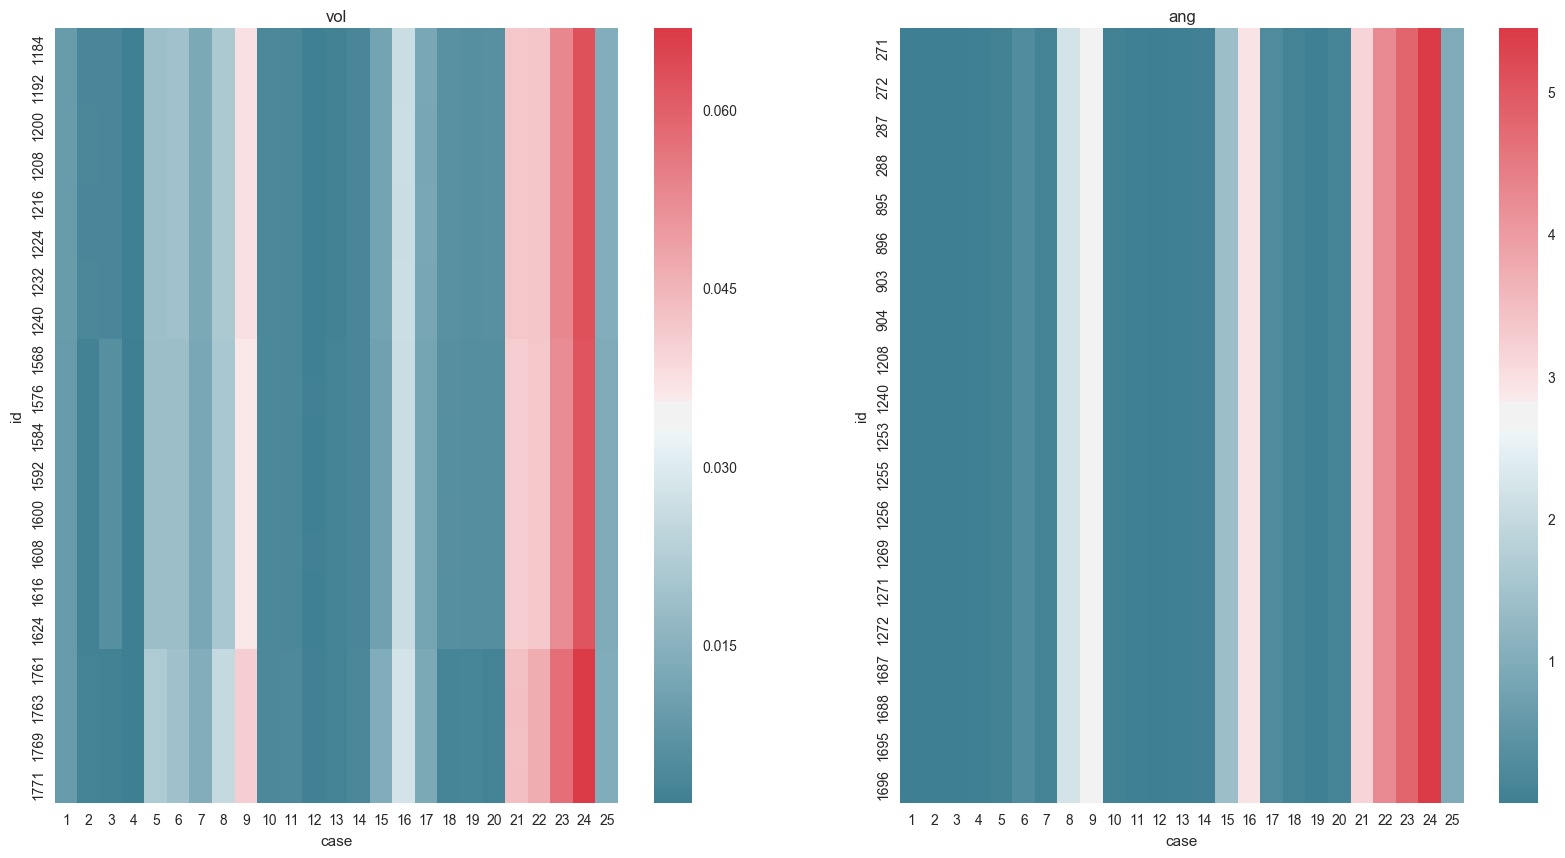

In [21]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(dfv3,cmap=cmap, ax=ax[0])
sns.heatmap(dfa3,cmap=cmap, ax=ax[1])
ax[0].set_title('vol')
ax[1].set_title('ang')
plt.show()

## Basic Statistics
We consider some basic statistics accross the cases. 
This helps further visualize the "cost" of picking one id over the other

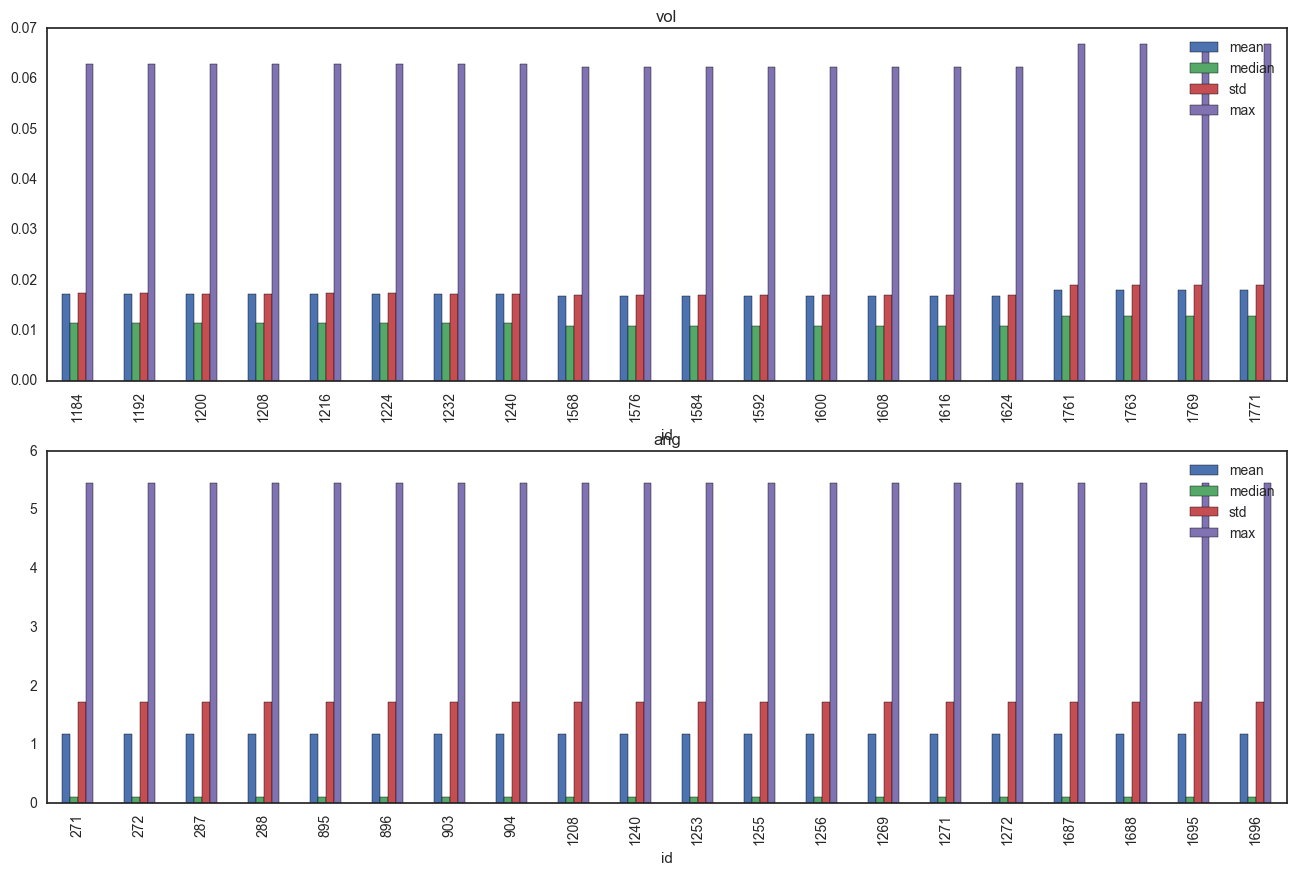

In [22]:
fig, ax = plt.subplots(2,1, figsize=(16,10))
# df3.mean(axis=1).plot(ax=ax[0],kind='line',label='mean')
tmpv = pd.DataFrame(index=dfv3.index, columns=['mean','median', 'std', 'max'], 
                   data=np.hstack([dfv3.mean(axis=1).values[:,np.newaxis], 
                                   dfv3.median(axis=1).values[:, np.newaxis],
                                   dfv3.std(axis=1).values[:, np.newaxis],
                                   dfv3.max(axis=1).values[:, np.newaxis]]))
tmpa = pd.DataFrame(index=dfa3.index, columns=['mean','median', 'std', 'max'], 
                   data=np.hstack([dfa3.mean(axis=1).values[:,np.newaxis], 
                                   dfa3.median(axis=1).values[:, np.newaxis],
                                   dfa3.std(axis=1).values[:, np.newaxis],
                                   dfa3.max(axis=1).values[:, np.newaxis]]))
tmpv.plot(kind='bar', ax=ax[0])
tmpa.plot(kind='bar', ax=ax[1])
ax[0].set_title('vol')
ax[1].set_title('ang')
plt.show()

## Index of best performace
Finally, we look at which index performed best for each summary statistic.

In [30]:
df_best = pd.concat([tmpv.idxmin(axis=0),tmpa.idxmin(axis=0)], axis=1).rename(columns={0:'vol', 1:'ang'})
df_best

,vol,ang
mean,1592,1255
median,1568,271
std,1592,1688
max,1592,1688


## Cross comparison
The next step is to consider the set of *best indecies* and how the perform for all the different caes.

In [39]:
best_ids = df_best.values.flatten()
df_cross = {}
df_cross['vol'] = dfv.loc[ dfv['id'].isin(best_ids), :].pivot(index='id', columns='case', values='value')
df_cross['ang'] = dfa.loc[ dfa['id'].isin(best_ids), :].pivot(index='id', columns='case', values='value')

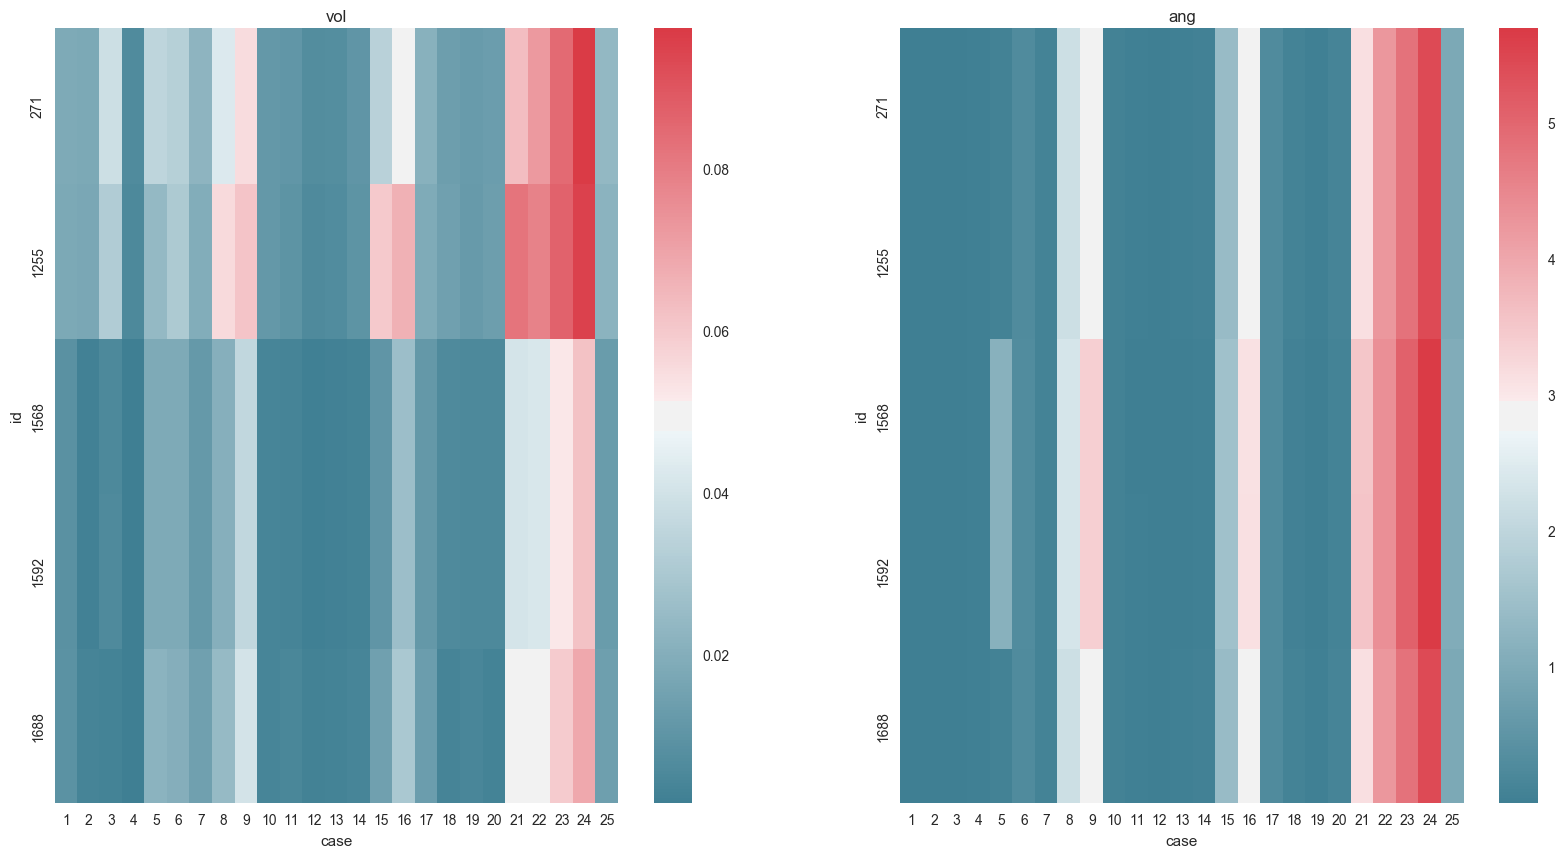

In [42]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
for i, s in enumerate(['vol', 'ang']):
    sns.heatmap(df_cross[s],cmap=cmap, ax=ax[i])
    ax[i].set_title(s)
plt.show()

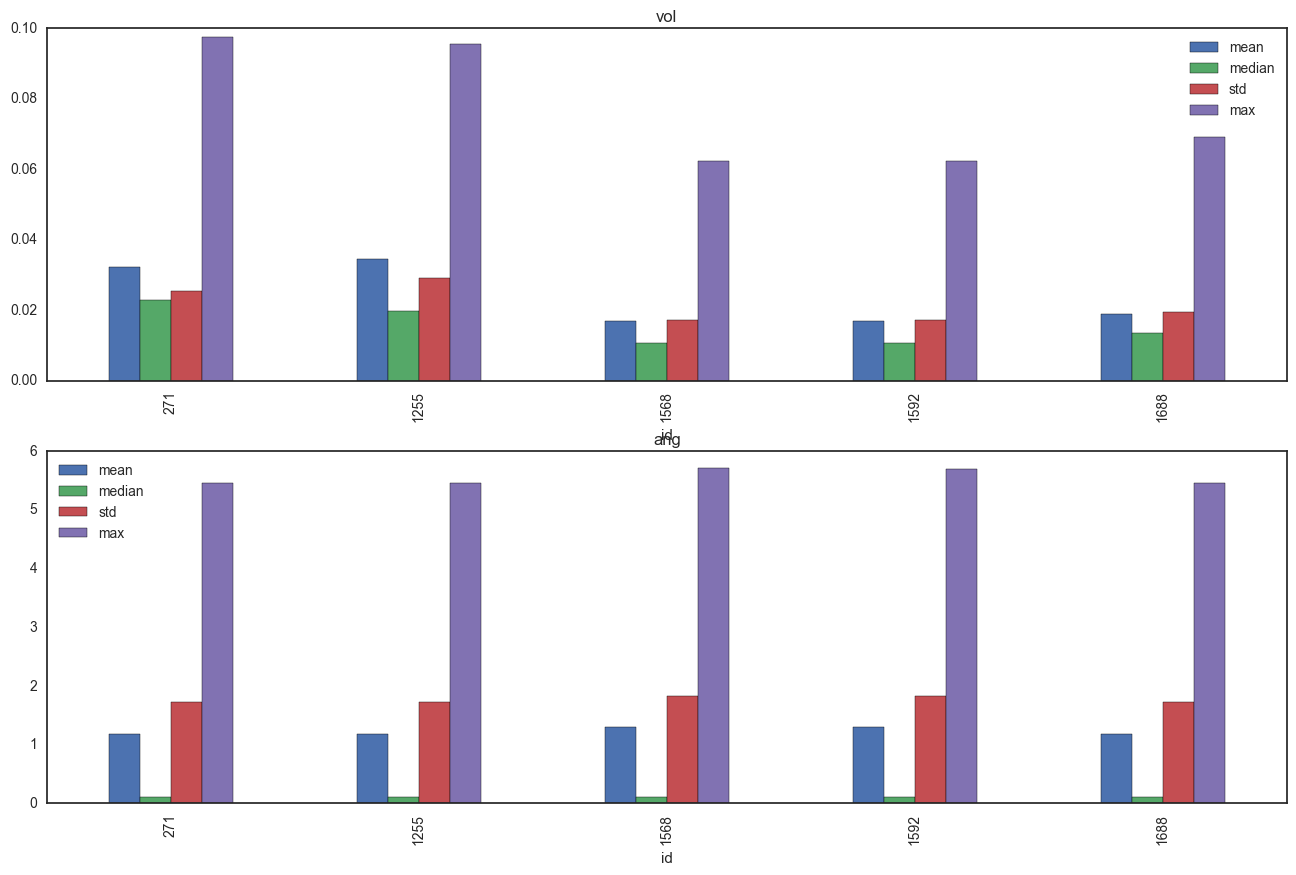

In [45]:
fig, ax = plt.subplots(2,1, figsize=(16,10))
for i, s in enumerate(['vol', 'ang']):
    df_cross[s + '_stats'] = pd.DataFrame(index=df_cross[s].index, columns=['mean','median', 'std', 'max'], 
                   data=np.hstack([df_cross[s].mean(axis=1).values[:,np.newaxis], 
                                   df_cross[s].median(axis=1).values[:, np.newaxis],
                                   df_cross[s].std(axis=1).values[:, np.newaxis],
                                   df_cross[s].max(axis=1).values[:, np.newaxis]]))
    df_cross[s + '_stats'].plot(kind='bar', ax=ax[i])
    ax[i].set_title(s)
plt.show()